In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import os
import sys
from argparse import ArgumentParser

# pytorch lighting
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint,EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# torch
import torch
import torch.nn as nn
from torchvision.models.resnet import resnet18
import torch.nn.functional as F
import torchmetrics

# General purpose
import numpy as np
import pandas as pd
from numpy import loadtxt

# Display image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import sklearn
import skimage
import matplotlib.cm as cm

# Clustering + Reduction
import umap
import umap.plot
import hdbscan
from sklearn.metrics import silhouette_score

from torch.utils.tensorboard import SummaryWriter

data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

BATCH_SIZE = 200

MIN_EPOCHS=30
MAX_EPOCHS=50


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

train_dataset.labels= train_dataset.labels.squeeze(1)
val_dataset.labels = val_dataset.labels.squeeze(1)
test_dataset.labels= test_dataset.labels.squeeze(1)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz


In [133]:
# torch
import torch
import torch.nn as nn
from torchvision.models.resnet import resnet18
import torch.nn.functional as F
import collections
from functools import partial
import torchvision.transforms as T
from torchmetrics.functional import accuracy
from torchmetrics import AUC

# pytorch lighting
import pytorch_lightning as pl

auroc = AUROC(num_classes=9)

def create_model(num_classes=10, pretrained=False):
    if (pretrained):
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        model = resnet18(pretrained=False, num_classes=num_classes)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model


class LitResnet(pl.LightningModule):
    def __init__(self, learning_rate=0.1,num_classes=10, pretrained=False, unc=False, mode='sup', batch_size=200):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model(num_classes, pretrained)
        self.activations = collections.defaultdict(list)  # a dictionary that keeps saving the activations as they come
        self.unc = unc
        self.n_aug = 5
        self.threshold = 80
        self.transforms = torch.nn.Sequential(
                                            T.RandomHorizontalFlip(p=0.8),
                                            T.RandomVerticalFlip(p=0.3),
        )
        self.unc_values = list()
        self.sup = list()
        self.mode = mode
        self.learning_rate=learning_rate
        self.batch_size= batch_size
        

    def save_activation(self, name, mod, inp, out):
        self.activations[name].append(out.cpu())

    def set_activations(self, save_activations=True):
        # a dictionary that keeps saving the activations as they come
        if save_activations:
            for name, m in self.model.named_modules():
                if name == 'avgpool':
                    # partial to assign the layer name to each hook
                    m.register_forward_hook(partial(self.save_activation, name))

    def unc_configuration(self, n_aug=5, threshold=80):
        self.n_aug = n_aug
        self.threshold = threshold

    def fine_tuning(self, dim_sub=10, freeze=False, deep_layer=False, dim_out=10):
        if deep_layer:
            self.model.fc = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(self.model.fc.in_features, dim_sub),
                        nn.Linear(dim_sub, dim_out)
            )

        else:
            self.model.fc = nn.Linear(self.model.fc.in_features, dim_out)
                
        if (freeze):
            # Freeze all layers just the classifier
            for name, parameters in self.model.named_parameters():
                # We freeze all the layers but the normalization ones and the fully connected layer
                if ('bn' not in name) and ('fc' not in name):
                    parameters.requires_grad = False   

    def forward(self, x):
        out = self.model(x)
        if self.unc:
            return F.softmax(out, dim=1)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        if self.mode == 'sup':
            x, y = batch
        else:
            x, y = batch
        y = y.to(device, dtype=torch.int64)
        logits = self(x)
        loss = F.nll_loss(logits,y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None, unc=None):
        if unc:
            x, y = batch                                          #si calcola l'incertezza per le superclassi
            aug = x.repeat(self.n_aug, 1, 1, 1)
            for i in range(self.n_aug):
                aug[i] = self.transforms(x)
            logits = self(aug)
            logits = torch.sum(logits, dim=0) / self.n_aug            #sono già probabilità
            pred, ind = torch.max(logits, dim=0)
            if ind == y:
                unc = 1 - pred
            else:
                unc = 1 + pred
            self.unc_values.append(unc.cpu())
            self.sup.append(y.cpu())
        else:
            if self.mode == 'sup':
                x, y = batch
            else:
                x, y = batch
            logits = self(x)
            y = y.to(device, dtype=torch.int64)

            loss = F.nll_loss(logits, y)
            preds = torch.argmax(logits, dim=1)
            acc = accuracy(preds, y)
            AUROC = auroc(logits, y)
            
            if stage:
                self.log(f"{stage}_loss", loss, prog_bar=True)
                self.log(f"{stage}_acc", acc, prog_bar=True)
                self.log(f"{stage}_auroc", AUROC, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        if(self.unc):
            self.evaluate(batch, "test_unc", self.unc)
        else:
            self.evaluate(batch, "test")

#    def configure_optimizers(self):
 #       optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9, nesterov=True)
  #      scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=0.00001, last_epoch=-1, verbose=True)
   #     return [optimizer], [scheduler]

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.learning_rate,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.000001,
                                                                         last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,8,16,32], gamma=0.2)
        return [optimizer], [scheduler]

C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [3]:
# Setting the seed
pl.seed_everything(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dataset ='crc'

CHECKPOINT_PATH = os.path.join(os.getcwd(), "results/crc")
directory = os.path.join(CHECKPOINT_PATH, 'classifier', dataset)
dir_sub = os.path.join(CHECKPOINT_PATH, 'classifier_sub', dataset)
dir_finetuning = os.path.join(CHECKPOINT_PATH, 'fine-tuning', dataset)
dir_multihead = os.path.join(CHECKPOINT_PATH, 'multihead', dataset)

Global seed set to 42


In [4]:
checkpoint_sup_callback = ModelCheckpoint(save_weights_only=True,
                                              mode="max",
                                              monitor="val_acc",
                                              dirpath=directory,
                                              )
checkpoint_sub_callback = ModelCheckpoint(save_weights_only=True,
                                                       mode="max",
                                                       monitor="val_acc",
                                                       dirpath=dir_sub,
                                                       )
checkpoint_supfinetuning_callback = ModelCheckpoint(save_weights_only=True,
                                                       mode="max",
                                                       monitor="val_acc",
                                                       dirpath=dir_finetuning,
                                                       )

In [5]:
model = LitResnet(pretrained=True, num_classes=9)
trainer = pl.Trainer(default_root_dir=directory,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     min_epochs=MIN_EPOCHS,
                     max_epochs=MAX_EPOCHS,
                     auto_lr_find=True,
                     callbacks=[checkpoint_sup_callback,
                                # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=5),
                                TQDMProgressBar(1)]  # Log learning rate every epoch
                     )
trainer.tune(model, train_loader, val_loader)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
checkpoint = torch.load(checkpoint_sup_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer.test(model, dataloaders=test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 42
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\asus\Documents\GitHub\WorkBook-MS-Giacomo-Capitani\new experiments\results\crc\classifier\crc\lr_find_temp_model_f55b969e-23a1-48f0-840f-89ce9fc5684d.ckpt
Learning rate set to 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | model      | ResNet     | 11.2 M
1 | transforms | Sequential | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.694    Total estimated model params size (MB)
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\asus\Documents\GitHub\WorkBook-MS-Giacomo-Capitani\new experiments\results\crc\classifier\crc exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9083565473556519, 'test_loss': 0.41096991300582886}
--------------------------------------------------------------------------------


[{'test_loss': 0.41096991300582886, 'test_acc': 0.9083565473556519}]

In [6]:
#attivazioni train

In [7]:
import torch.utils.data as data
train_dataset = DataClass(split='train', transform=data_transform, download=download)

train_dataset.labels= train_dataset.labels.squeeze(1)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
checkpoint = torch.load(checkpoint_sup_callback.best_model_path)
model = LitResnet(num_classes=n_classes)
model.load_state_dict(checkpoint['state_dict'])
#attiva hook per estrarre l'ultimo layer
model.set_activations()
trainer = pl.Trainer(default_root_dir=directory,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     callbacks=[TQDMProgressBar(1)]
                     )
trainer.test(model, dataloaders=train_loader)

# concatenate all the outputs we saved to get the the activations for each layer for the whole dataset
activations = {name: torch.cat(outputs, 0) for name, outputs in model.activations.items()}

os.mkdir('sub_' + dataset)
np.savetxt('sub_' + dataset + '/train_activations.csv', torch.squeeze(activations['avgpool']).tolist(), delimiter=',')

Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9999666810035706, 'test_loss': 0.00022080104099586606}
--------------------------------------------------------------------------------


In [8]:
#attivazioni validation

In [9]:
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

checkpoint = torch.load(checkpoint_sup_callback.best_model_path)
model = LitResnet(num_classes=n_classes)
model.load_state_dict(checkpoint['state_dict'])
#attiva hook per estrarre l'ultimo layer
model.set_activations()
trainer = pl.Trainer(default_root_dir=directory,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     callbacks=[TQDMProgressBar(1)]
                     )
trainer.test(model, dataloaders=val_loader)

# concatenate all the outputs we saved to get the the activations for each layer for the whole dataset
activations = {name: torch.cat(outputs, 0) for name, outputs in model.activations.items()}

np.savetxt('sub_' + dataset + '/val_activations.csv', torch.squeeze(activations['avgpool']).tolist(), delimiter=',')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9877049326896667, 'test_loss': 0.04567890986800194}
--------------------------------------------------------------------------------


In [10]:
#incertezza trainset

In [11]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
#unc=True attiva la funzione per calcolare l'incertezza
model = LitResnet(num_classes=n_classes, unc=True)
checkpoint = torch.load(checkpoint_sup_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer = pl.Trainer(default_root_dir=directory,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     callbacks=[TQDMProgressBar(1)]
                     )
trainer.test(model, dataloaders=train_loader)
np.savetxt('sub_' + dataset + '/incertezza.csv', model.unc_values, delimiter=',')
np.savetxt('sub_' + dataset + '/superclassi.csv', model.sup, delimiter=',')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\numpy\core\_asarray.py:102: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order

In [12]:
#incertezza validation

In [13]:
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
#unc=True attiva la funzione per calcolare l'incertezza
model = LitResnet(num_classes=n_classes, unc=True)
checkpoint = torch.load(checkpoint_sup_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer = pl.Trainer(default_root_dir=directory,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     callbacks=[TQDMProgressBar(1)]
                     )
trainer.test(model, dataloaders=val_loader)
np.savetxt('sub_' + dataset + '/incertezza_val.csv', model.unc_values, delimiter=',')
np.savetxt('sub_' + dataset + '/superclassi_val.csv', model.sup, delimiter=',')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [14]:
#pseudolabels train

In [15]:
features = loadtxt('sub_' + dataset + '\\train_activations.csv', delimiter=',')
df = pd.DataFrame(features)
df['incertezza'] = loadtxt('sub_' + dataset + '\incertezza.csv', delimiter=',')
df['superclasse'] = loadtxt('sub_' + dataset + '\superclassi.csv', delimiter=',')
mapper= 0
clusterer=0


features_val = loadtxt('sub_' + dataset + '\\val_activations.csv', delimiter=',')
df_val = pd.DataFrame(features_val)
df_val['incertezza'] = loadtxt('sub_' + dataset + '\incertezza_val.csv', delimiter=',')
df_val['superclasse'] = loadtxt('sub_' + dataset + '\superclassi_val.csv', delimiter=',')

# lista delle superclassi
Uniquesuper = df.superclasse.unique()
# I vari dataframe divisi per superclasse

DataFrameDict = {elem: pd.DataFrame for elem in Uniquesuper}
for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.superclasse == key]
    
for key in DataFrameDict.keys():
    df = DataFrameDict[key]  # dataframe di una superclasse
    px = df.sort_values(by=['incertezza'])  # ordiniamo in ordine crescente
    first = px.head(int(len(px) * (90 / 100)))
    # salviamo gli indici degli elementi più certi nel dataframe della superclasse
    indexes = first.index.tolist()
    for index in indexes:
        df.loc[index, 'incerto'] = 0  # gli elementi più certi li settiamo a 0
    df['incerto'].fillna(1, inplace=True)  # gli altri a 1, cosi abbiamo la nostra maschera
    DataFrameDict[key] = df
    

    
DataFrameDict_val = {elem: pd.DataFrame for elem in Uniquesuper}

for key in DataFrameDict_val.keys():
    DataFrameDict_val[key] = df_val[:][df_val.superclasse == key]
    
for key in DataFrameDict_val.keys():
    df_val = DataFrameDict_val[key]  # dataframe di una superclasse
    px_val = df_val.sort_values(by=['incertezza'])  # ordiniamo in ordine crescente
    first_val = px_val.head(int(len(px_val) * (90 / 100)))
    # salviamo gli indici degli elementi più certi nel dataframe della superclasse
    indexes_val = first_val.index.tolist()
    for index in indexes_val:
        df_val.loc[index, 'incerto'] = 0  # gli elementi più certi li settiamo a 0
    df_val['incerto'].fillna(1, inplace=True)  # gli altri a 1, cosi abbiamo la nostra maschera
    DataFrameDict_val[key] = df_val
    
    
num_sub = 0
#clusterizziamo solo gli elementi meno incerti che saranno settati nella mask.csv a 0
for key in DataFrameDict.keys():
    df_super = DataFrameDict[key].loc[DataFrameDict[key]['incerto'] == 0]
    data = df_super.drop(columns=['incerto', 'incertezza', 'superclasse'])
    mapper = umap.UMAP(
        n_neighbors=30,
        min_dist=0.0,
        n_components=4,
        random_state=42,
    ).fit(data)
    data = mapper.embedding_
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100, prediction_data=True).fit(data)
    soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
    cluster_labels = [np.argmax(x)
                      for x in soft_clusters]
    #np.savetxt('sub_' + self.dataset + '/' + str(key) + '_embeddings.csv', data, delimiter=',')
    #np.savetxt('sub_' + self.dataset + '/' + str(key) + '_clusters.csv', cluster_labels, delimiter=',')
    silhouette_avg = silhouette_score(data, cluster_labels)
    writer = SummaryWriter('./run/sub_' + dataset + '/' + str(key) + '_embeddings_' + str(silhouette_avg) +'.csv')
    writer.add_embedding(data, metadata=cluster_labels, global_step=1)
    df_super['subclass'] = cluster_labels
    df_super['subclass'] = [x + num_sub for x in df_super['subclass']]
    
    indexes = df_super.index.tolist()
    for index in indexes:
        DataFrameDict[key].loc[index, 'subclass'] = df_super.loc[index, 'subclass']
    DataFrameDict[key]['subclass'].fillna(-1, inplace=True)  # gli altri a -1
    
    #validation 
    
    df_super_val = DataFrameDict_val[key].loc[DataFrameDict_val[key]['incerto'] == 0]
    data_val = df_super_val.drop(columns=['incerto', 'incertezza', 'superclasse'])
    data_val = mapper.transform(data_val)
    soft_clusters_val= hdbscan.prediction.membership_vector(clusterer, data_val)
    cluster_labels_val = [np.argmax(x)
                      for x in soft_clusters_val]
    
    df_super_val['subclass'] = cluster_labels_val
    df_super_val['subclass'] = [x + num_sub for x in df_super_val['subclass']]
    indexes_val = df_super_val.index.tolist()
    for index in indexes_val:
        DataFrameDict_val[key].loc[index, 'subclass'] = df_super_val.loc[index, 'subclass']
    DataFrameDict_val[key]['subclass'].fillna(-1, inplace=True)  # gli altri a -1
    
    
    num_sub += df_super['subclass'].nunique()
    
final = pd.DataFrame()
final_val = pd.DataFrame()
for key in DataFrameDict.keys():
    final = pd.concat([final, DataFrameDict[key]])
    final_val = pd.concat([final_val, DataFrameDict_val[key]])

final=final.sort_index()
final_val=final_val.sort_index()
np.savetxt('sub_' + dataset + '/pseudo.csv', final['subclass'].astype(int), delimiter=',')
np.savetxt('sub_' + dataset + '/mask.csv', final['incerto'].astype(int), delimiter=',')

np.savetxt('sub_' + dataset + '/pseudo_val.csv', final_val['subclass'].astype(int), delimiter=',')
np.savetxt('sub_' + dataset + '/mask_val.csv', final_val['incerto'].astype(int), delimiter=',')
#np.savetxt('sub_' + dataset + '/new_super.csv', final['superclasse'].astype(int), delimiter=',')

C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [16]:
#pseudolabels validation va fatto tutto nello stesso for

In [17]:
#pseudo train

In [18]:
pseudo = loadtxt('sub_crc' + '\pseudo.csv', delimiter=',')
superclass = loadtxt('sub_crc'+'\superclassi.csv', delimiter=',')
mask = loadtxt('sub_crc'+'\mask.csv', delimiter=',')
mask = torch.tensor(mask)
idx = list()
for i in torch.nonzero(mask == 0):
    idx.append(i)
    
train_dataset = DataClass(split='train', transform=data_transform, download=download)
train_dataset.labels=pseudo
train_set = torch.utils.data.Subset(train_dataset, idx)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,num_workers=0, shuffle=True)

Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz


In [19]:
#pseudo validation

In [116]:
pseudo = loadtxt('sub_crc' + '\pseudo_val.csv', delimiter=',')
superclass = loadtxt('sub_crc'+'\superclassi_val.csv', delimiter=',')
mask = loadtxt('sub_crc'+'\mask_val.csv', delimiter=',')
mask = torch.tensor(mask)
idx = list()
for i in torch.nonzero(mask == 0):
    idx.append(i)
    
val_dataset = DataClass(split='val', transform=data_transform, download=download)
val_dataset.labels=pseudo
val_set = torch.utils.data.Subset(val_dataset, idx)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,num_workers=0, shuffle=False)

Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz


In [21]:
len(np.unique(val_dataset.labels))-1

58

In [22]:
#allenamento modell sottoclasse train+validation

In [23]:
patience=5

In [24]:
n_sub = len(np.unique(train_dataset.labels))-1
model = LitResnet(pretrained=True, num_classes=n_sub, mode='sub')
trainer = pl.Trainer(default_root_dir=dir_sub,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     min_epochs=MIN_EPOCHS,
                     max_epochs=MAX_EPOCHS,
                     auto_lr_find=True,
                     callbacks=[checkpoint_sub_callback,
                                # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                LearningRateMonitor("epoch"), # Log learning rate every epoch
                                EarlyStopping('val_loss', patience=patience),
                                TQDMProgressBar(1)]
                     )
trainer.tune(model, train_loader, val_loader)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
checkpoint = torch.load(checkpoint_sub_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer.test(model, dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 42
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\asus\Documents\GitHub\WorkBook-MS-Giacomo-Capitani\new experiments\results\crc\classifier_sub\crc\lr_find_temp_model_c554c9dd-798c-4ed8-836e-28c9650020b0.ckpt
Learning rate set to 0.025118864315095822
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | model      | ResNet     | 11.2 M
1 | transforms | Sequential | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.796    Total estimated model params size (MB)
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\asus\Documents\GitHub\WorkBook-MS-Giacomo-Capitani\new experiments\results\crc\classifier_sub\crc exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8149794340133667, 'test_loss': 1.5483871698379517}
--------------------------------------------------------------------------------


[{'test_loss': 1.5483871698379517, 'test_acc': 0.8149794340133667}]

In [25]:
#fine-tuning

In [26]:
# carichiamo il modello allenato sulle sottoclassi, cambiamo l'output e frezziamo i parametri di tutta la rete
# esclusi classificatore e batch-norm
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)


train_dataset.labels= train_dataset.labels.squeeze(1)
val_dataset.labels = val_dataset.labels.squeeze(1)
test_dataset.labels= test_dataset.labels.squeeze(1)


# encapsulate data into dataloader form
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

checkpoint = torch.load(checkpoint_sub_callback.best_model_path)
model = LitResnet(num_classes=n_sub)
model.load_state_dict(checkpoint['state_dict'])
model.fine_tuning(dim_out=n_classes, freeze=False)
trainer = pl.Trainer(default_root_dir=dir_finetuning ,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     min_epochs=MIN_EPOCHS,
                     max_epochs=MAX_EPOCHS,
                     auto_lr_find=True,
                     callbacks=[checkpoint_supfinetuning_callback,
                                # Save the best checkpoint based on the maximum val_acc recorded.
                                # Saves only weights and not optimizer
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=patience),
                                TQDMProgressBar(1)]  # Log learning rate every epoch
                     )
trainer.tune(model, train_loader, val_loader)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
checkpoint = torch.load(checkpoint_supfinetuning_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer.test(model, dataloaders=test_loader)

Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\asus\Documents\GitHub\WorkBook-MS-Giacomo-Capitani\new experiments\results\crc\fine-tuning\crc\lr_find_temp_model_85d944fb-dadf-4a87-92a2-6bf378dda3b7.ckpt
Learning rate set to 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | model      | ResNet     | 11.2 M
1 | transforms | Sequential | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.694    Total estimated model params size (MB)
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\asus\Documents\GitHub\WorkBook-MS-Giacomo-Capitani\new experiments\results\crc\fine-tuning\crc exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.905153214931488, 'test_loss': 0.4448249638080597}
--------------------------------------------------------------------------------


[{'test_loss': 0.4448249638080597, 'test_acc': 0.905153214931488}]

In [28]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
invTrans = T.Compose([  T.Normalize(mean = [ 0., 0., 0. ],std = [1/0.5, 1/0.5, 1/0.5]),
                        T.Normalize(mean = [-0.5, -0.5, -0.5],std = [ 1., 1., 1. ]),
                               ])

def show(imgs, **imshow_kwargs):
    num_rows = 1
    num_cols = 10
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    fig.set_size_inches(25, 25)
    for col_idx in range(num_cols):
        ax = axs[0, col_idx]
        ax.imshow(np.asarray(imgs[col_idx]), **imshow_kwargs)
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz


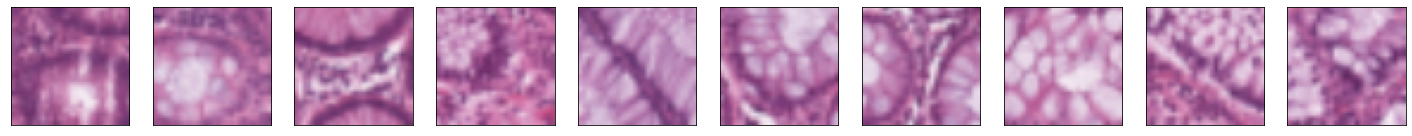

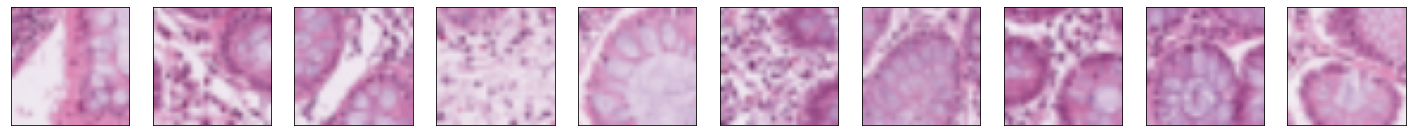

In [72]:
pseudo = loadtxt('sub_crc' + '\pseudo.csv', delimiter=',')
superclass = loadtxt('sub_crc'+'\superclassi.csv', delimiter=',')
mask = loadtxt('sub_crc'+'\mask.csv', delimiter=',')
mask = torch.tensor(mask)
idx = list()
for i in torch.nonzero(mask == 0):
    idx.append(i)
    
train_dataset = DataClass(split='train', transform=data_transform, download=download)
train_dataset.labels=pseudo

grid= list()
i=0
for c in range(57,59):
    imgs = list()
    for data in train_dataset:
        img,label = data
        if(label==c):
            #print(label)
            img=invTrans(img)
            img = T.ToPILImage()(img.to('cpu'))
            img=T.Resize(50)(img)
            imgs.append(img)
        if len(imgs) > 9:
            #grid.append(imgs)
            show(imgs)
            break

In [39]:
superclass

array([0., 4., 7., ..., 2., 0., 2.])

In [40]:
df = pd.DataFrame()
df['sottoclasse'] = pseudo
df['superclasse'] = superclass

In [41]:
df

,sottoclasse,superclasse
0,1.0,0.0
1,3.0,4.0
2,4.0,7.0
3,20.0,5.0
4,25.0,5.0
...,...,...
89991,1.0,0.0
89992,58.0,6.0
89993,44.0,2.0
89994,1.0,0.0


In [50]:
df['sottoclasse'][df.superclasse==8]

5        28.0
10       35.0
12       30.0
20       33.0
23       27.0
         ... 
89969    26.0
89973    30.0
89974    34.0
89977    37.0
89980    30.0
Name: sottoclasse, Length: 12885, dtype: float64

In [52]:
df.groupby('superclasse')['sottoclasse'].unique()

superclasse
0.0                                     [1.0, 0.0, -1.0]
1.0    [47.0, 51.0, 52.0, 55.0, 46.0, 54.0, 45.0, 48....
2.0                       [44.0, 43.0, -1.0, 41.0, 42.0]
3.0                             [39.0, 38.0, -1.0, 40.0]
4.0                                     [3.0, -1.0, 2.0]
5.0    [20.0, 25.0, 23.0, 16.0, 19.0, 24.0, 21.0, 22....
6.0                                   [58.0, 57.0, -1.0]
7.0    [4.0, 14.0, -1.0, 7.0, 12.0, 10.0, 6.0, 8.0, 1...
8.0    [28.0, 35.0, 30.0, 33.0, 27.0, 36.0, 34.0, 37....
Name: sottoclasse, dtype: object

In [64]:
df.groupby('superclasse')['sottoclasse'].nunique()-1

superclasse
0.0     2
1.0    12
2.0     4
3.0     3
4.0     2
5.0    10
6.0     2
7.0    12
8.0    12
Name: sottoclasse, dtype: int64

In [114]:
model = LitResnet(num_classes=n_sub)
model.fine_tuning(dim_out=n_classes, freeze=False)
checkpoint = torch.load(checkpoint_supfinetuning_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\asus\anaconda3\envs\class-discovery\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.905153214931488,
 'test_auroc': 0.9825373888015747,
 'test_loss': 0.4448249638080597}
--------------------------------------------------------------------------------


[{'test_loss': 0.4448249638080597,
  'test_acc': 0.905153214931488,
  'test_auroc': 0.9825373888015747}]

In [109]:
model = LitResnet(num_classes=9)
checkpoint = torch.load(checkpoint_sup_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9083565473556519,
 'test_auroc': 0.9897828698158264,
 'test_loss': 0.41096991300582886}
--------------------------------------------------------------------------------


[{'test_loss': 0.41096991300582886,
  'test_acc': 0.9083565473556519,
  'test_auroc': 0.9897828698158264}]

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def createConfusionMatrix(loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = model(inputs)  # Feed Network
        preds = torch.argmax(output, dim=1).data.cpu().numpy()
        #output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(preds)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = ('0', '1', '2', '3', '4',
               '5', '6', '7', '8')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    #/np.sum(cf_matrix) * 10
    df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(12, 7))    
    return sn.heatmap(df_cm, annot=True).get_figure()

In [152]:
from torch.utils.tensorboard import SummaryWriter

checkpoint = torch.load(checkpoint_supfinetuning_callback.best_model_path)

#model = LitResnet(num_classes=n_sub)
#model.fine_tuning(dim_sub=n_sub, freeze=False, deep_layer=True, dim_out=n_classes)
#model.load_state_dict(checkpoint['state_dict'])

model = LitResnet(num_classes=9)
checkpoint = torch.load(checkpoint_sup_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
# tensorboard file
writer = SummaryWriter('runs/confusion')

# Save confusion matrix to Tensorboard
writer.add_figure("Confusion matrix", createConfusionMatrix(test_loader), 7)

In [135]:
# carichiamo il modello allenato sulle sottoclassi, cambiamo l'output
# load the data

train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)


train_dataset.labels= train_dataset.labels.squeeze(1)
val_dataset.labels = val_dataset.labels.squeeze(1)
test_dataset.labels= test_dataset.labels.squeeze(1)


# encapsulate data into dataloader form
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

checkpoint = torch.load(checkpoint_sub_callback.best_model_path)
model = LitResnet(num_classes=n_sub)
model.load_state_dict(checkpoint['state_dict'])
model.fine_tuning(dim_sub=n_sub, freeze=False, deep_layer=True, dim_out=n_classes)
trainer = pl.Trainer(default_root_dir=dir_finetuning ,  # Where to save models
                     gpus=1 if str(device) == "cuda:0" else 0,  # We run on a single GPU (if possible)
                     min_epochs=MIN_EPOCHS,
                     max_epochs=MAX_EPOCHS,
                     auto_lr_find=True,
                     callbacks=[checkpoint_supfinetuning_callback,
                                # Save the best checkpoint based on the maximum val_acc recorded.
                                # Saves only weights and not optimizer
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=patience),
                                TQDMProgressBar(1)]  # Log learning rate every epoch
                     )
trainer.tune(model, train_loader, val_loader)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
checkpoint = torch.load(checkpoint_supfinetuning_callback.best_model_path)
model.load_state_dict(checkpoint['state_dict'])
trainer.test(model, dataloaders=test_loader)

Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\asus\.medmnist\pathmnist.npz


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\asus\Documents\GitHub\WorkBook-MS-Giacomo-Capitani\new experiments\results\crc\fine-tuning\crc\lr_find_temp_model_2ee842a2-43cd-443e-8d16-1e6cacbacf6e.ckpt
Learning rate set to 0.030199517204020192
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | model      | ResNet     | 11.2 M
1 | transforms | Sequential | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.799    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9165738224983215,
 'test_auroc': 0.9840299487113953,
 'test_loss': 0.40481483936309814}
--------------------------------------------------------------------------------


[{'test_loss': 0.40481483936309814,
  'test_acc': 0.9165738224983215,
  'test_auroc': 0.9840299487113953}]